In [255]:
#default_exp charge

# PV Forecasting

<br>

## Battery charging: problem definition

The goal of the battery charging component is to maximise the amount of charge that is drawn from solar PV, as opposed to the grid. We want to maximise: 

$$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$

summing over all $k$ periods during which we can charge. We are allowed to charge during $k=1,...31$ or between 00:00 and 15:30 (that is the settlement period ending at 15:30).

##### Constraints

As with the battery discharge, the battery has a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

##### Output

The output should be roughly the same as the battery discharge, except with positive values to indicate charging. E.g.

```
charging_profile = [
0, ## 00:00--00:30
0, ## 00:30--01:00
...
1.2, ## 14:30--15:00
0.7] ## 15:00--15:30

```

### Imports

In [256]:
#exports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from moepy.lowess import quantile_model

from batopt import clean
from batopt.discharge import sample_random_day

import FEAutils as hlp

In [257]:
# Should do some investigation of how the panel temp influences performance

In [258]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

In [259]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,,,,,
2017-11-03 00:00:00+00:00,2.19,0.0,7.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.560,9.640,7.46,6.680,13.090,13.20
2017-11-03 00:30:00+00:00,2.14,0.0,7.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.625,9.675,7.30,6.475,13.150,13.26
2017-11-03 01:00:00+00:00,2.01,0.0,7.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.690,9.710,7.14,6.270,13.210,13.32
2017-11-03 01:30:00+00:00,1.87,0.0,7.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.715,9.720,7.00,6.090,13.255,13.34
2017-11-03 02:00:00+00:00,1.86,0.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.740,9.730,6.86,5.910,13.300,13.36


Correlations between the solar variables:

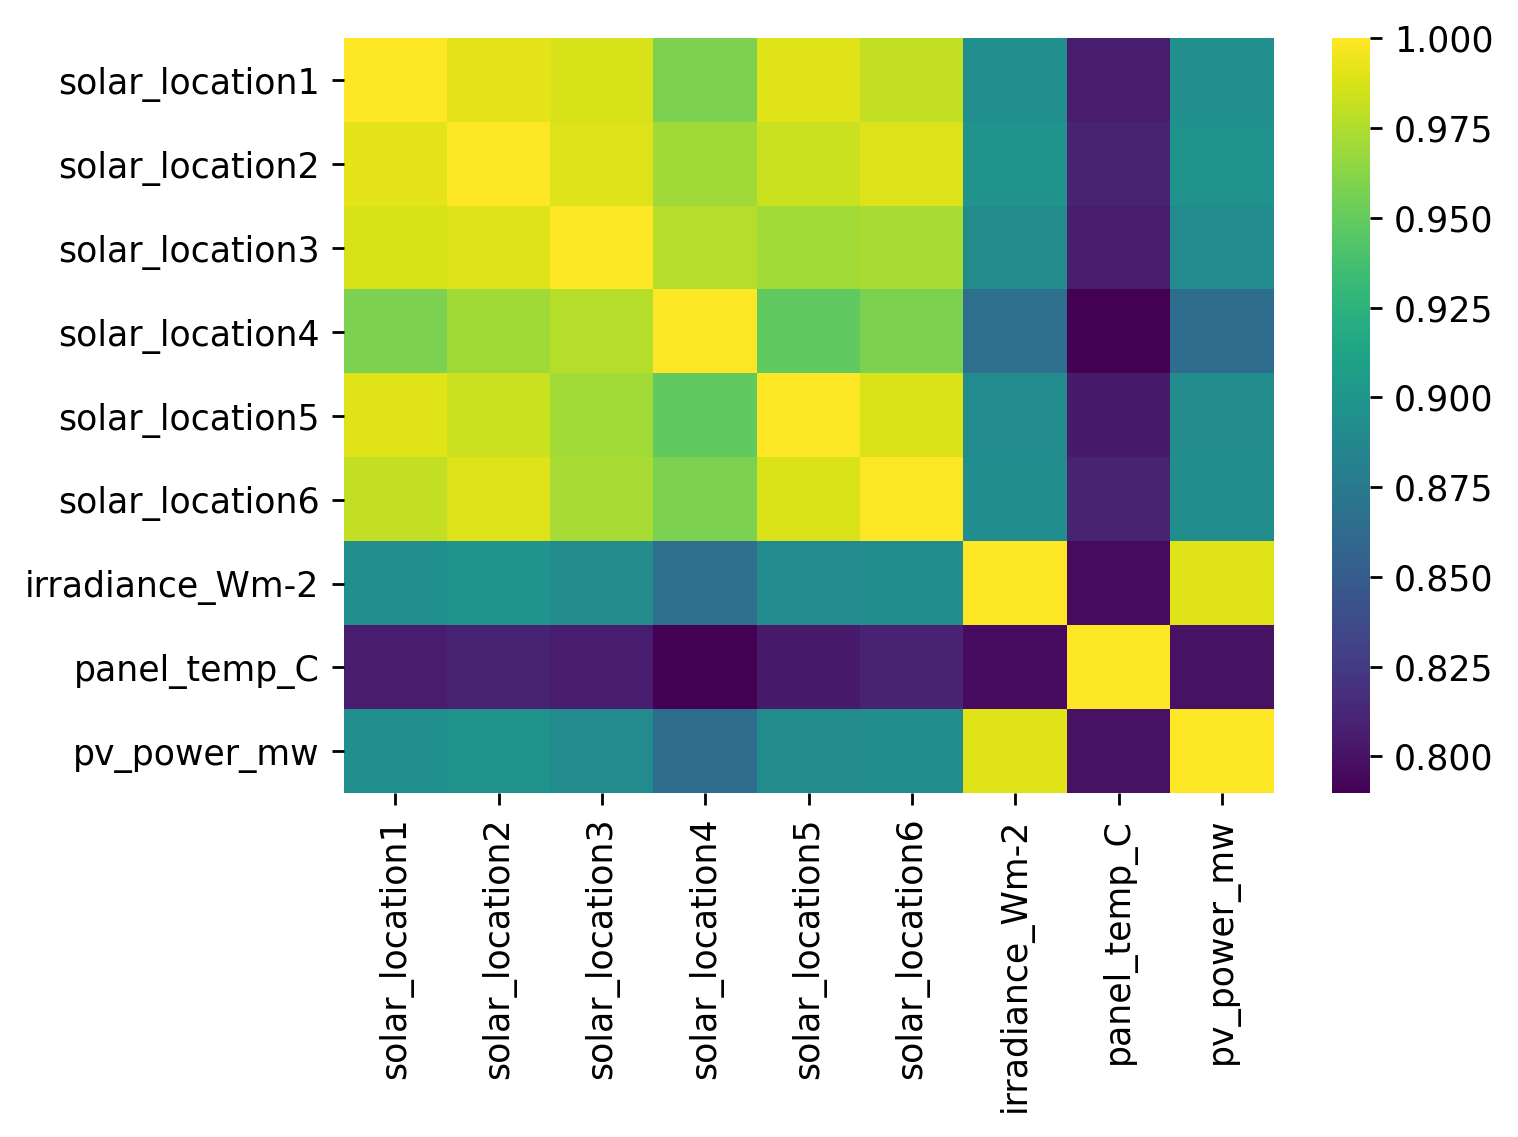

In [260]:
solar_cols = [c for c in df.columns if 'solar_location' in c]
solar_cols.append('irradiance_Wm-2')
solar_cols.append('panel_temp_C')
solar_cols.append('pv_power_mw')

fig, ax = plt.subplots(dpi=250)
df_solar = df.filter(solar_cols).copy()
ax = sns.heatmap(df_solar.corr(), cmap='viridis')
fig.savefig('../img/solar_corrplot.png')

As in the demand data, estimating the quantiles for the solar PV output:

In [261]:
#exports
def estimate_daily_solar_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

dts = df.index.tz_convert('Europe/London')
x = np.array(dts.hour + dts.minute/60)
y = df['pv_power_mw'].values

rerun_daily_solar_model = False
daily_solar_filename = 'daily_solar_quantile_model_results.csv'

if (rerun_daily_solar_model == True) or (daily_solar_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_solar_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_solar_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_demand_filename}', index_col='x')

And plotting

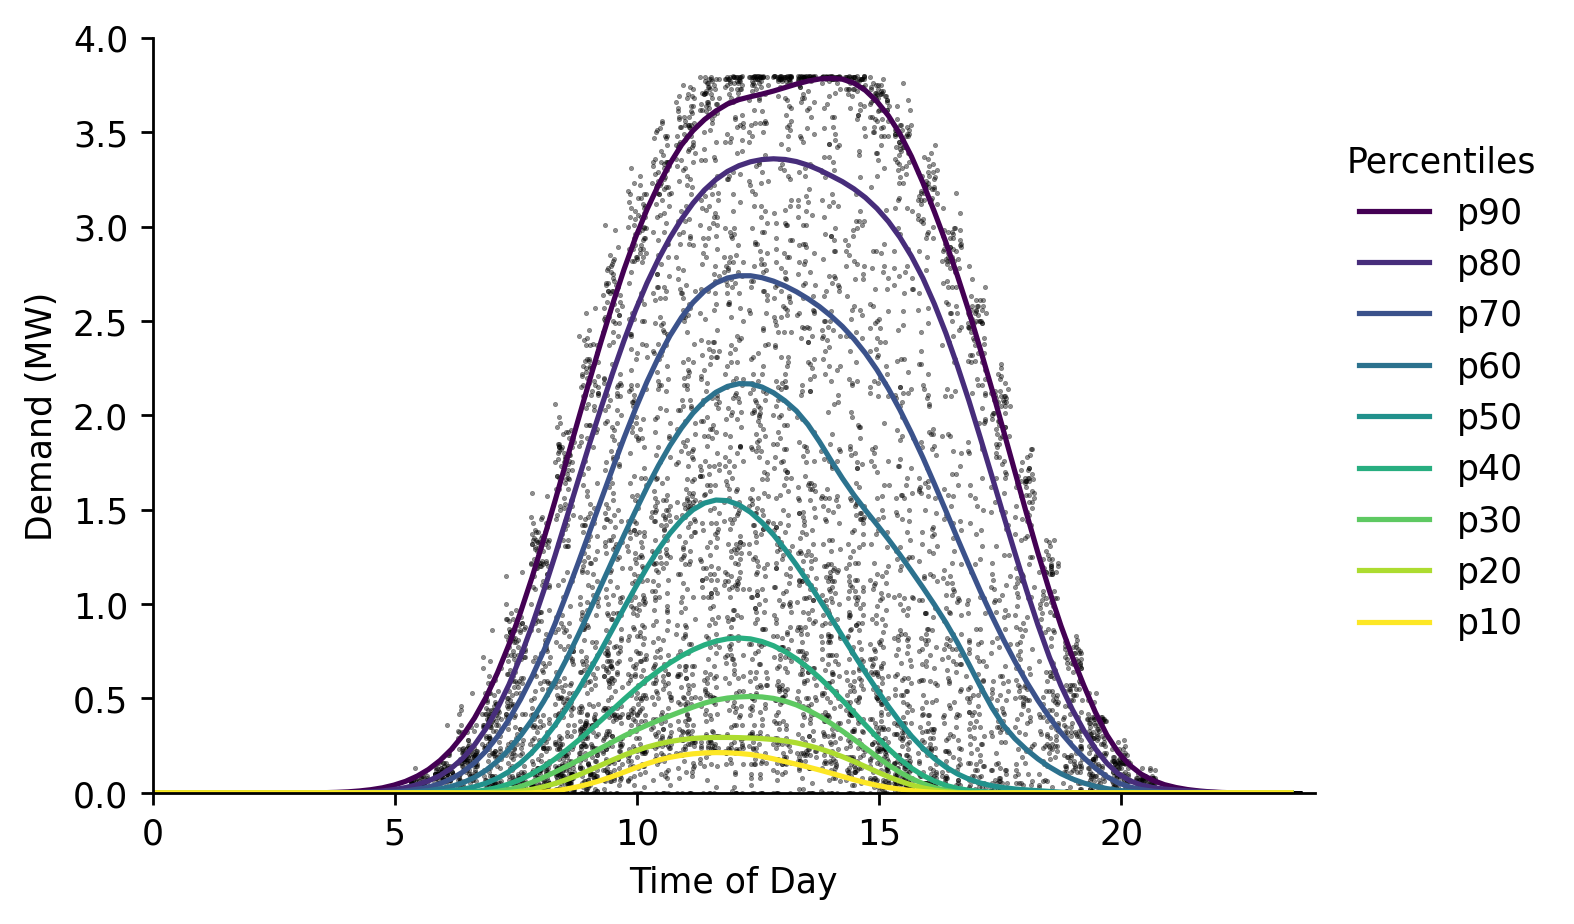

In [262]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(0, 4)

fig.savefig('../img/daily_solar_profile.png')

## Proportion of days during which we can fully charge the battery

It may be useful to know the proportion of days during which the battery can be fully charged. 

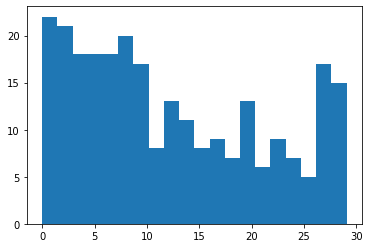

Proportion of days where solar generation exceeds 6 MWh: 69.08%


In [263]:
df_solar_hrs = df.between_time('00:00:00', '15:00:00')
pv_generation = df_solar_hrs.groupby(df_solar_hrs.index.date).sum()['pv_power_mw']*0.5 # available daily energy from PV

fig, ax = plt.subplots()
ax.hist(pv_generation, bins=20)
plt.show()

prop = np.sum(pv_capacity >= 6)/pv_capacity.size
print("Proportion of days where solar generation exceeds 6 MWh: {:.2f}%".format(prop*100))

## Optimal charging with perfect foresight

We will now develop an algorithm to determine the optimal charging schedule given a perfect solar forecast. 

In [264]:
#exports
def extract_solar_profile(s_solar_sample_dt, start_time='00:00', end_time='15:00'):
    dt = str(s_solar_sample_dt.index[0].date())
    solar_profile = s_solar_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return solar_profile

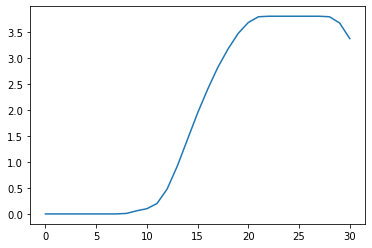

In [265]:
pv = df['pv_power_mw']

plt.plot(random_day)

The scoring function for the generation component rewards us taking as much energy as possible from solar PV. The proportion of energy from PV for a day $d$ is given by $$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$ where we are summing over all periods $k$. An equivalent equation is applies for $p_{d,2}$ which is the energy that is drawn from the grid. The scoring function rewards $p_{d,1}$ over $p_{d,2}$ in a ratio of 3 to 1. 

For perfect foresight, any schedule that draws all of the available solar power or 6 MWh (if the total solar production exceeds 6 MWh) is equally good. This approach will aim to draw greedily from  until 6 MWh is satisfied, or all of the solar production has been expended.

In [300]:
#exports

def charge_profile(solar_profile, capacity=6, max_charge_rate=2.5, time_unit=0.5):
    charge = 0
    order = np.flip(np.argsort(random_day))
    solution = np.zeros(len(solar_profile))
    for i in order:
        solar_available = np.minimum(solar_profile[i], max_charge_rate)
        solar_available = min(solar_available, (capacity - charge)/time_unit)        
        charge += solar_available * time_unit
        solution[i] = solar_available
        if charge > capacity:
            break
    assert(np.sum(time_unit*solution) <= capacity), f"Too much charge: {np.sum(solution)}"
    return solution

for i in range(100):
    random_day = sample_random_day(pv).pipe(extract_solar_profile)
    x = charge_profile(random_day) # Note there is sometimes a rounding error here
plt.plot(x)


AssertionError: Too much charge: 12.000000000000002

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()